# HY2B SWH对比

In [1]:
from HaiYangData import *
import glob
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def polar_plot(x_map, y_map,grid, vmax ,vmin,color_lable=None,title=None,cmap = plt.cm.jet):
    m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
    m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,vmin=vmin, vmax=vmax,latlon = True)
    cb = m.colorbar(location='bottom')
    if color_lable:
        cb.set_label(color_lable)
    m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
    plt.title(title)


In [3]:
# 设置空间分辨率
years = ['2020']
months = ['09'] 
time_window = 3600 
resolution = 25000
output_dir = r'E:\\HLCourse\\experiment_marine_technology\\finally_project\\output\\'
dataframe_dir = r'E:\\HLCourse\\experiment_marine_technology\\finally_project\\dataframe\\'

In [4]:
# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

In [5]:
hy_alt = HaiYangData(satellite='hy', sensor='alt',resolution=resolution)
cy_siral = HaiYangData(satellite='cy', sensor='siral',resolution=resolution)
is_atlas = HaiYangData(satellite='is', sensor='atlas',resolution=resolution)

In [6]:
hyfiles = []
hy_value = ['swh_ku','swh_c','mean_sea_surface','rain_flag','ice_flag','surface_type']
hy_fill_value = 32767
for yea in years:
    for mon in months:
        hy_dir_path = r'G:\\remote_sensing_data\\hy2b\\ALT\\'+ yea + '\\' + mon
        hyfiles = hyfiles + (glob.glob(hy_dir_path + '\*.nc'))
hyfiles.sort()


In [7]:

hy_ori_df = pd.DataFrame(np.column_stack((hy_alt.alt_from_nc_files(hyfiles, value=hy_value))), columns=['lon', 'lat', 'time']+hy_value)




In [8]:
# 删除无效点,只处理北纬66°以上的数据
# 删除降雨、冰、陆地的点
hy_df = hy_ori_df.drop(list(np.where(hy_ori_df['swh_ku'] == hy_fill_value)[0][:]))
hy_df = hy_alt.data_filter(hy_df,'lat',66)
hy_df = hy_df.drop(hy_df[(hy_df.rain_flag != 0)].index)
hy_df = hy_df.drop(hy_df[(hy_df.ice_flag != 0)].index)
hy_df = hy_df.drop(hy_df[(hy_df.surface_type == 2)].index)

In [9]:
# hy_df.to_csv(dataframe_dir + 'hy' +str( years) + str(months) + '.csv')

In [6]:
hy_df = pd.read_csv(dataframe_dir+'hy' +str( years) + str(months) + '.csv')

In [7]:
# 将投影数据添加到dataframe中
hy_alt.add_proj(hy_df, transformer)


In [8]:

# 交叉点平均化
hy_swh_grid = hy_alt.coincident_point_mean(hy_df,'swh_ku')
hy_ssh_grid = hy_alt.coincident_point_mean(hy_df,'mean_sea_surface')
# 获得XYmgrid
hy_x_map, hy_y_map = hy_alt.get_map_grid(transformer_back)

<ipython-input-2-24430fa1c0e5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,vmin=vmin, vmax=vmax,latlon = True)


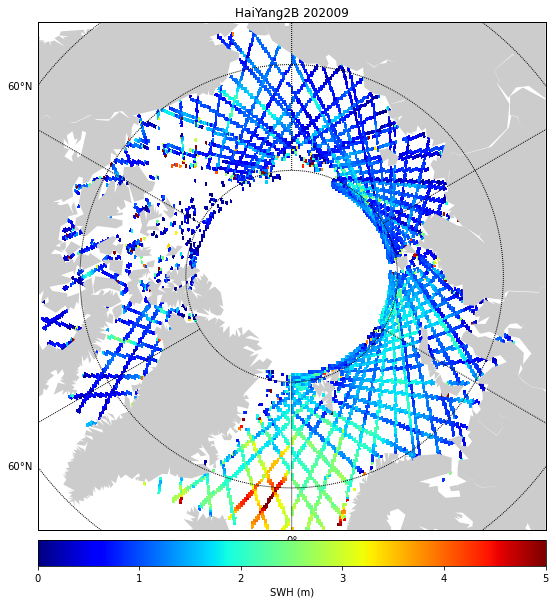

In [9]:
plt.figure(figsize=(10, 10))
polar_plot(hy_x_map, hy_y_map,hy_swh_grid,vmin=0, vmax=5,color_lable='SWH (m)',title='HaiYang2B '+str(years[0]) + str(months[0]))
# plt.savefig(r'output/'+ str( years) + str(months)  +' HY' + 'swh' +' '+ 'location_plot.jpg')
plt.show()

In [10]:
hy_df = hy_df.drop(hy_df[hy_df.mean_sea_surface > 500].index)

<AxesSubplot:>

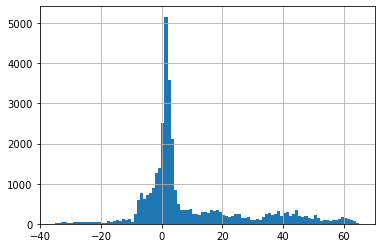

In [11]:
hy_df.mean_sea_surface.hist(bins=100)


<ipython-input-2-24430fa1c0e5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,vmin=vmin, vmax=vmax,latlon = True)


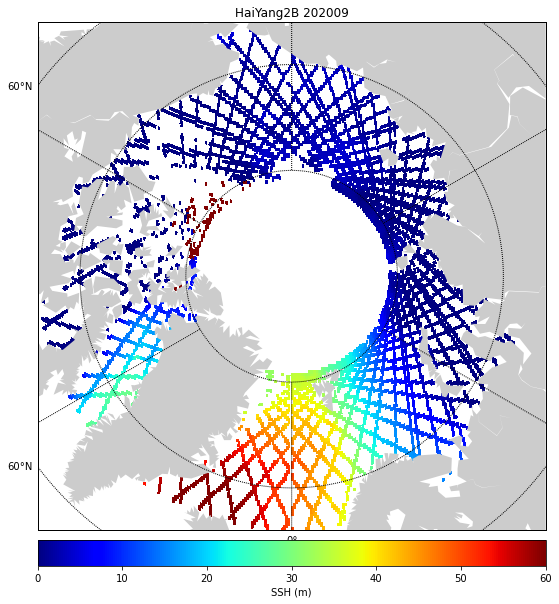

In [12]:
plt.figure(figsize=(10, 10))
polar_plot(hy_x_map, hy_y_map,hy_ssh_grid,vmin=0, vmax=60,color_lable='SSH (m)',title='HaiYang2B '+str(years[0]) + str(months[0]))
# plt.savefig(r'output/'+ str( years) + str(months)  +' HY' + 'ssh' +' '+ 'location_plot.jpg')
plt.show()

# Cryosat 数据处理

In [13]:
cyfiles = []
cy_fill_value = -32768

for yea in years:
    for mon in months:
        cy_dir_path = r'G:\\remote_sensing_data\\cryosat2\\LRM_L2\\'+yea + '\\' + mon
        cyfiles = cyfiles + (glob.glob(cy_dir_path + '\*.nc'))
cyfiles.sort()

In [18]:

cy_value = ['swh_ocean_01_ku','mean_sea_surf_sea_ice_01']

cy_ori_df = pd.DataFrame(np.column_stack((cy_siral.cy_siral_from_nc(cyfiles, value=cy_value))), columns=['lon', 'lat', 'time']+cy_value)

# 删除无效点,只处理北纬66°以上的数据
cy_df = cy_ori_df.drop(list(np.where(cy_ori_df['swh_ocean_01_ku'] == cy_fill_value)[0][:]))
cy_df = cy_siral.data_filter(cy_df,'lat',66)

In [19]:
# cy_df.to_csv(dataframe_dir+'cy' +str( years) + str(months) + '.csv')

In [15]:

cy_df = pd.read_csv(r"E:\\HLCourse\\experiment_marine_technology\\finally_project\\dataframe\\"+'cy' +str( years) + str(months) + '.csv')

In [16]:
# 将投影数据添加到dataframe中
cy_siral.add_proj(cy_df, transformer)

# 交叉点平均化
cy_swh_grid = cy_siral.coincident_point_mean(cy_df,'swh_ocean_01_ku')

# 获得XYmgrid
cy_x_map, cy_y_map = cy_siral.get_map_grid(transformer_back)

In [17]:
plt.figure(figsize=(10, 10))
polar_plot(cy_x_map, cy_y_map,cy_swh_grid,vmin=0, vmax=5,color_lable='SWH (m)',title='Cryosat2 '+str(years[0]) + str(months[0]))
# plt.savefig(r'output/'+ str( years) + str(months)  +' CY' + 'swh' +' '+ 'location_plot.jpg')
plt.close()

<ipython-input-2-24430fa1c0e5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,vmin=vmin, vmax=vmax,latlon = True)


# ICESAT2 数据处理

In [13]:

# icesat2 的时间是从2018-01-01 00：00：00开始记的，Hy2b和cryosat2的是从2000-01-01 00：00：00开始计的
# 2018-01-01 00：00：00 与2000-01-01 00：00：00 相差了568080000秒
correction_second = 568080000        
is_fill_value = 32767
isfiles = []
is_value = ['swh']        
for yea in years:
    for mon in months:
        is_dir_path = r'G:\\remote_sensing_data\\icesat2\\'+yea + '\\' + mon
        isfiles = isfiles + (glob.glob(is_dir_path + '\\*.h5'))
isfiles.sort()



In [15]:

is_value = ['swh','h']

is_ori_df = pd.DataFrame(np.column_stack((is_atlas.is_atlas_from_nc(isfiles, value=is_value))), columns=['lon', 'lat', 'time','prc_land','prc_ocean','prc_sea_ice','prc_land_ice','prc_inland_water',]+is_value)

In [16]:
# 删除无效点,只处理北纬66°以上的数据
is_df = is_ori_df.drop(list(np.where(is_ori_df['swh'] == is_fill_value)[0][:]))
is_df = is_df.drop(is_df[(is_df.lat < 66)].index)

In [17]:
is_df.to_csv(dataframe_dir+'is' +str( years) + str(months) + '.csv')
# is_df = pd.read_csv(r"E:\\HLCourse\\experiment_marine_technology\\finally_project\\dataframe\\"+'is' +str( years) + str(months) + '.csv')

# 将投影数据添加到dataframe中
is_atlas.add_proj(is_df, transformer)
is_land_df = is_df[is_df['prc_land'] == 100.0]
is_ocean_df = is_df[is_df['prc_ocean'] == 100.0]
is_seaice_df = is_df[is_df['prc_sea_ice'] == 100.0]
is_landice_df = is_df[is_df['prc_land_ice'] == 100.0]
is_inlandwater_df = is_df[is_df['prc_inland_water'] == 100.0]

# 交叉点平均化
is_land_grid = is_atlas.coincident_point_mean(is_land_df,'swh')
is_ocean_grid = is_atlas.coincident_point_mean(is_ocean_df,'swh')
is_seaice_grid = is_atlas.coincident_point_mean(is_seaice_df,'swh')
is_landice_grid = is_atlas.coincident_point_mean(is_landice_df,'swh')
is_inlandwater_grid = is_atlas.coincident_point_mean(is_inlandwater_df,'swh')

In [18]:
is_df = is_df[(is_df['prc_ocean'] == 100.0) & (is_df['prc_land_ice'] == 0.0)& (is_df['prc_inland_water'] == 0.0)&  (is_df['prc_land'] == 0.0)]
# is_df = is_df[(is_df['prc_land_ice'] == 0.0)& (is_df['prc_inland_water'] == 0.0)& (is_df['prc_land'] == 0.0)]

In [19]:
# 将投影数据添加到dataframe中
is_atlas.add_proj(is_df, transformer)
# 交叉点平均化
is_swh_grid = is_atlas.coincident_point_mean(is_df,'swh')
is_ssh_grid = is_atlas.coincident_point_mean(is_df,'h')
# 获得XYmgrid
is_x_map, is_y_map = is_atlas.get_map_grid(transformer_back)

fig = plt.figure(figsize=(30,20) )    # 生成新的画布fig

ax1 = fig.add_subplot(231) 
# polar_plot(is_x_map, is_y_map,is_mean_grid,title='ori',vmax = 5,vmin = 0,color_lable='SWH (m)')
ax2 = fig.add_subplot(232)
polar_plot(is_x_map, is_y_map,is_land_grid,title='land',vmax = 5,vmin = 0,color_lable='SWH (m)')
ax3 = fig.add_subplot(233) 
polar_plot(is_x_map, is_y_map,is_ocean_grid,title='ocean',vmax = 5,vmin = 0,color_lable='SWH (m)')
ax4 = fig.add_subplot(234) 
polar_plot(is_x_map, is_y_map,is_seaice_grid,title='seaice',vmax = 5,vmin = 0,color_lable='SWH (m)')
ax5 = fig.add_subplot(235) 
polar_plot(is_x_map, is_y_map,is_landice_grid,title='landice',vmax = 5,vmin = 0,color_lable='SWH (m)')
ax6 = fig.add_subplot(236) 
polar_plot(is_x_map, is_y_map,is_inlandwater_grid,title='inlandwater',vmax = 5,vmin = 0,color_lable='SWH (m)')
plt.savefig(output_dir +str( years) + str(months)+ 'icesat2_surface_type_prcnt.jpg',bbox_inches='tight', dpi=150)

<AxesSubplot:>

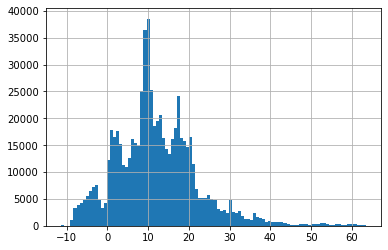

In [20]:
is_df.h.hist(bins=100)


<ipython-input-2-24430fa1c0e5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,vmin=vmin, vmax=vmax,latlon = True)
<ipython-input-2-24430fa1c0e5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,vmin=vmin, vmax=vmax,latlon = True)


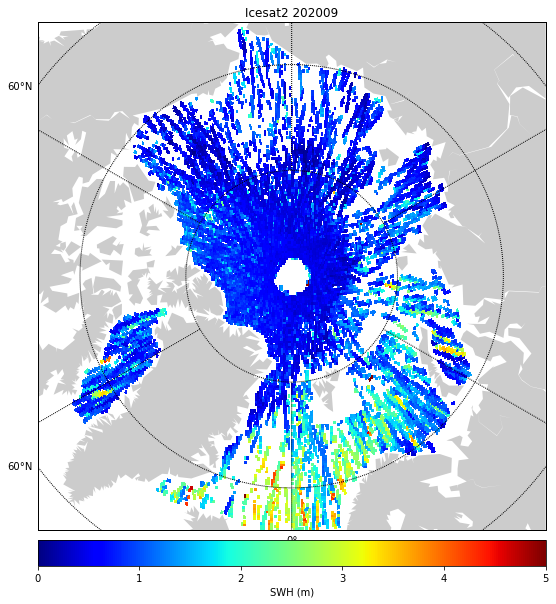

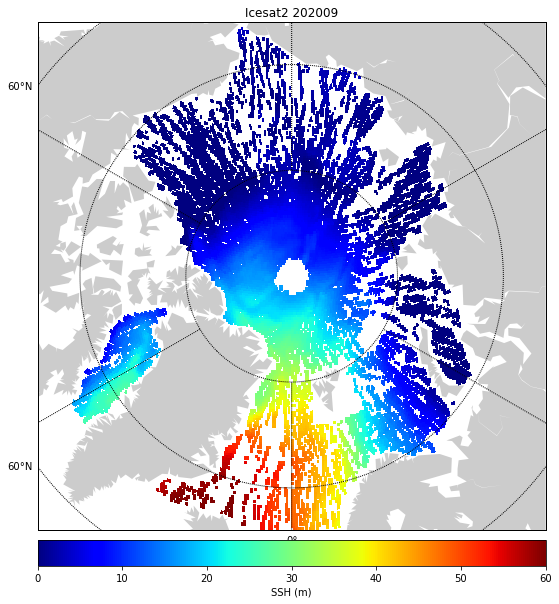

In [21]:
fig = plt.figure(figsize=(10,10) )    # 生成新的画布fig
polar_plot(is_x_map, is_y_map,is_swh_grid,vmax = 5,vmin = 0,color_lable='SWH (m)',title='Icesat2 '+str(years[0]) + str(months[0]))
plt.savefig(r'output/'+ str( years) + str(months)  +' IS' + 'swh' +' '+ 'location_plot.jpg')

fig = plt.figure(figsize=(10,10) )    # 生成新的画布fig
polar_plot(is_x_map, is_y_map,is_ssh_grid,vmax = 60,vmin = 0,color_lable='SSH (m)',title='Icesat2 '+str(years[0]) + str(months[0]))
plt.savefig(r'output/'+ str( years) + str(months)  +' IS' + 'ssh' +' '+ 'location_plot.jpg')

In [22]:

is_swh_time_dict = dict(is_atlas.coincident_time_log(is_df,value='swh'))
is_ssh_time_dict = dict(is_atlas.coincident_time_log(is_df,value='h'))

In [23]:


hy_swh_time_dict = dict(hy_alt.coincident_time_log(hy_df,value='swh_ku'))
hy_ssh_time_dict = dict(hy_alt.coincident_time_log(hy_df,value='mean_sea_surface'))

In [20]:
# cy_swh_time_dict = dict(cy_siral.coincident_time_log(cy_df,value='swh_ocean_01_ku'))

# 对比hy与cryosat交叉点


In [ ]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = hy_swh_grid - cy_swh_grid
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)

In [ ]:
# 创建一个用来存储点对的list
hy_cy_coincident_list = []
hy_cy_time_list = []
for i in range(hy_cy_diff_grid.shape[0]): 
    diff_x = hy_cy_diff_grid[i][0]
    diff_y = hy_cy_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    try:
                   
        for cy_time_key in cy_swh_time_dict[key].keys():
            for hy_time_key in hy_swh_time_dict[key].keys():
                hy_cy_time_list.append(np.abs(hy_time_key - cy_time_key))
                hy_cy_time_list.append(key)

                if np.abs(hy_time_key - cy_time_key)< time_window :
                    coincident_value = []
                    coincident_value.append(key)
                    coincident_value.append(hy_time_key)
                    coincident_value.append(hy_swh_time_dict[key][hy_time_key])
                    coincident_value.append(cy_time_key)
                    coincident_value.append(cy_swh_time_dict[key][cy_time_key])
                    hy_cy_coincident_list.append(coincident_value)
    except KeyError:
        print(key)

In [20]:
hy_cy_df = pd.DataFrame(hy_cy_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_cy_df['hy_time_round'] = ((hy_cy_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_cy_df['other_time_round'] = ((hy_cy_df['other_time'].astype(np.float))/time_window).astype(np.int)
hy_cy_df['diff'] = hy_cy_df['hy_value'] - hy_cy_df['other_value']

In [21]:
hy_cy_mean_df = hy_cy_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_cy_mean_df['diff'] = hy_cy_mean_df['hy_value'] - hy_cy_mean_df['other_value']


DataError: No numeric types to aggregate

In [ ]:
hy_cy_mean_df.to_csv(dataframe_dir+'HY&CY swh' +str( years) + str(months) + '.csv')

In [ ]:
'''hy_cy_mean_df = hy_cy_mean_df.drop(hy_cy_mean_df[hy_cy_mean_df.hy_value > hy_cy_mean_df['diff'].std() * 5 ].index)
hy_cy_mean_df = hy_cy_mean_df.drop(hy_cy_mean_df[hy_cy_mean_df.other_value > hy_cy_mean_df['diff'].std() * 5 ].index)'''

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_cy_mean_df['hy_value'], hy_cy_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,5),np.linspace(0,5),color='r')
x_tick = range(0,5,2)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(0.5, 2.8, 'Bias = '+str(round(hy_cy_mean_df['diff'].mean(), 3)))
plt.text(0.5, 2.6, 'STD = '+str(round(hy_cy_mean_df['diff'].std(), 3)))
plt.text(0.5,2.4,'Sample# = ' + str(hy_cy_mean_df.shape[0]))
plt.text(0.5,3,'RMSE = ' + str(round(np.sqrt(mean_squared_error(hy_cy_mean_df['hy_value'], hy_cy_mean_df['other_value'])),3)))
plt.text(0.5,3.2,'R^2 = ' + str(round(r2_score(hy_cy_mean_df['hy_value'], hy_cy_mean_df['other_value']),3)))
plt.xlabel('HY2B ' + 'swh' + '(m)')

plt.ylabel('CRYOSAT2 ' + 'swh' + '(m)')
plt.title(str(years) + str(months) + 'HY & CY SWH' )
# plt.savefig(r'output/'+ str( years) + str(months)  +'HY & CY' + 'swh' +' '+ 'scatter_plot.jpg')

# HY和CRYOSAT2交叉点在图像上绘制出来

In [ ]:
hy_cy_draw_df = hy_cy_df.groupby(['ij']).mean()
hy_cy_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_cy_draw_df.index):
    hy_cy_draw_diff_grid[int(index.split('+')[0])][int(index.split('+')[1])] = hy_cy_draw_df.loc[hy_cy_draw_df.index[i]]['diff']


In [ ]:
plt.figure(figsize=(9, 9))
polar_plot(cy_x_map, cy_y_map,hy_cy_draw_diff_grid,vmax=1, vmin = -1,color_lable='SWH (m)',title='HY & CY '+str(years[0]) + str(months[0]))
plt.savefig(r'output/'+ str( years) + str(months)  +'HY & CY' + 'swh' +' '+ 'location_plot.jpg')

# 对比hy与icesat交叉点 SWH


In [24]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = hy_swh_grid - is_swh_grid
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)


In [25]:
# 创建一个用来存储点对的list
hy_is_coincident_list = []
hy_is_time_list = []
for i in range(hy_is_diff_grid.shape[0]): 
    diff_x = hy_is_diff_grid[i][0]
    diff_y = hy_is_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    try:
        for is_time_key in is_swh_time_dict[key].keys():
            for hy_time_key in hy_swh_time_dict[key].keys():
                hy_is_time_list.append(np.abs(hy_time_key - is_time_key))
                hy_is_time_list.append(key)

                if np.abs(hy_time_key - is_time_key)< time_window :
                    coincident_value = []
                    coincident_value.append(key)
                    coincident_value.append(hy_time_key)
                    coincident_value.append(hy_swh_time_dict[key][hy_time_key])
                    coincident_value.append(is_time_key)
                    coincident_value.append(is_swh_time_dict[key][is_time_key])
                    hy_is_coincident_list.append(coincident_value)
    except KeyError:
        print(key)

404+-66
404+-64
405+-69
405+-64
406+-69
406+-65
406+-64
407+-72
407+-69
407+-67
407+-64
408+-71
408+-67
408+-63
409+-70
409+-63
410+-62
412+-62
412+-61
413+-68
414+-64
414+-61
415+-66
415+-60
416+-73
416+-65
417+-73
417+-59
418+-69
418+-62
418+-61
418+-60
418+-59
418+-58
419+-72
419+-59
419+-58
420+-58
420+-57
421+-69
421+-58
422+-73
422+-69
422+-56
423+-71
423+-70
423+-55
424+-62
424+-61
424+-52
425+-72
425+-51
426+-72
426+-57
426+-53
427+-59
428+-58
428+-56
428+-55
428+-50
428+-47
429+-51
429+-44
430+-59
430+-58
434+-63
435+-50
435+-36
436+-51
437+-31
438+-35
438+-34


In [26]:
hy_is_df = pd.DataFrame(hy_is_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_is_df['hy_time_round'] = ((hy_is_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_is_df['other_time_round'] = ((hy_is_df['other_time'].astype(np.float))/time_window).astype(np.int)

hy_is_mean_df = hy_is_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_is_mean_df['diff'] = hy_is_mean_df['hy_value'] - hy_is_mean_df['other_value']

DataError: No numeric types to aggregate

In [ ]:
hy_is_mean_df.to_csv(dataframe_dir+'HY&IS swh' +str( years) + str(months) + '.csv')

In [ ]:
'''hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df['diff'] > hy_is_mean_df['diff'].std() * 5 ].index)
hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df['diff'] < np.negative(hy_is_mean_df['diff'].std() * 5) ].index)'''

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,4),np.linspace(0,4),color='r')
x_tick = range(0,5,1)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(0.5, 2.8, 'Bias = '+str(round(hy_is_mean_df['diff'].mean(), 3)))
plt.text(0.5, 2.6, 'STD = '+str(round(hy_is_mean_df['diff'].std(), 3)))
plt.text(0.5,2.4,'Sample# = ' + str(hy_is_mean_df.shape[0]))
plt.text(0.5,3,'RMSE = ' + str(round(np.sqrt(mean_squared_error(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value'])),3)))
plt.text(0.5,3.2,'R^2 = ' + str(round(r2_score(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value']),3)))

plt.xlabel('HY2B ' + 'swh' + '(m)')
plt.ylabel('ICESAT2 ' + 'swh' + '(m)')
plt.title('HY & IS SWH '+str(years[0]) + str(months[0]) )

plt.savefig(r'output/scatter_plot/'+ str( years) + str(months)  +'HY & IS' + 'swh' +' '+ 'scatter_plot.jpg')

# HY和IS交叉点SWH在图像上绘制出来

In [ ]:
hy_is_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_is_mean_df.index):
    hy_is_draw_diff_grid[int(index[0].split('+')[0])][int(index[0].split('+')[1])] = hy_is_mean_df.loc[hy_is_mean_df.index[i]]['diff']


In [ ]:
plt.figure(figsize=(9, 9))
polar_plot(is_x_map, is_y_map,hy_is_draw_diff_grid,vmax=1, vmin = -1,color_lable='SWH (m)',title='HY & IS '+str(years[0]) + str(months[0]))
plt.savefig(r'output/'+ str( years) + str(months)  +'HY & IS' + 'swh' +' '+ 'location_plot.jpg')

# 对比HY和ICESAT2 SSH的数据

In [ ]:
# 创建一个用来存储点对的list
hy_is_ssh_coincident_list = []
hy_is_time_list = []
for i in range(hy_is_diff_grid.shape[0]): 
    diff_x = hy_is_diff_grid[i][0]
    diff_y = hy_is_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    try:
        for is_time_key in is_ssh_time_dict[key].keys():
            for hy_time_key in hy_ssh_time_dict[key].keys():
                hy_is_time_list.append(np.abs(hy_time_key - is_time_key))
                hy_is_time_list.append(key)

                if np.abs(hy_time_key - is_time_key)< time_window :
                    coincident_value = []
                    coincident_value.append(key)
                    coincident_value.append(hy_time_key)
                    coincident_value.append(hy_ssh_time_dict[key][hy_time_key])
                    coincident_value.append(is_time_key)
                    coincident_value.append(is_ssh_time_dict[key][is_time_key])
                    hy_is_ssh_coincident_list.append(coincident_value)
    except KeyError:
        print(key)

In [ ]:
hy_is_df = pd.DataFrame(hy_is_ssh_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_is_df['hy_time_round'] = ((hy_is_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_is_df['other_time_round'] = ((hy_is_df['other_time'].astype(np.float))/time_window).astype(np.int)

hy_is_mean_df = hy_is_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_is_mean_df['diff'] = hy_is_mean_df['hy_value'] - hy_is_mean_df['other_value']

In [ ]:
hy_is_mean_df.to_csv(dataframe_dir+'HY&IS ssh' +str( years) + str(months) + '.csv')

In [ ]:
'''hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df.hy_value > hy_is_mean_df['diff'].std() * 5 ].index)
hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df.other_value > hy_is_mean_df['diff'].std() * 5 ].index)'''

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,60),np.linspace(0,60),color='r')
x_tick = range(0,61,10)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(10, 30, 'Bias = '+str(round(hy_is_mean_df['diff'].mean(), 3)))
plt.text(10, 35, 'STD = '+str(round(hy_is_mean_df['diff'].std(), 3)))
plt.text(10,40,'Sample# = ' + str(hy_is_mean_df.shape[0]))
plt.text(10,45,'RMSE = ' + str(round(np.sqrt(mean_squared_error(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value'])),3)))
plt.text(10,50,'R^2 = ' + str(round(r2_score(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value']),3)))

plt.xlabel('HY2B ' + 'ssh' + '(m)')
plt.ylabel('ICESAT2 ' + 'ssh' + '(m)')
plt.title('HY & IS SSH '+str(years[0]) + str(months[0]) )

# plt.savefig(r'output/'+'2019-2020' +  str(months) +'HY & IS' + 'ssh' +' '+ 'scatter_plot.jpg')
plt.savefig(r'output/scatter_plot/'+ str( years) + str(months)  +'HY & IS' + 'ssh' +' '+ 'scatter_plot.jpg')

# HY和IS交叉点 SSH在图像上绘制出来

In [ ]:
hy_is_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_is_mean_df.index):
    hy_is_draw_diff_grid[int(index[0].split('+')[0])][int(index[0].split('+')[1])] = hy_is_mean_df.loc[hy_is_mean_df.index[i]]['diff']


In [ ]:
plt.figure(figsize=(9, 9))
polar_plot(is_x_map, is_y_map,hy_is_draw_diff_grid,vmax=1, vmin = -1,color_lable='SSH (m)',title='HY & IS '+str(years[0]) + str(months[0]))
plt.savefig(r'output/'+ str( years) + str(months)  +'HY & IS' + 'ssh' +' '+ 'location_plot.jpg')

# 计算交叉点最多的日期

import datetime
def conver_time(julian_time):
    '''
    将从'2000-01-01 00:00:00 开始的JulianDay 转换为%Y-%m-%d %H:%M:%S 格式的时间
    '''
    strTime = '2000-01-01 00:00:00'
    startTime = datetime.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S") 
    Time = (startTime + datetime.timedelta(seconds=julian_time)).strftime("%Y-%m-%d %H:%M:%S")
    return Time


    

hy_is_mean_df['hy_day'] = (hy_is_mean_df['hy_time']/86400).astype(np.int)
hy_is_mean_df['other_day'] = (hy_is_mean_df['other_time']/86400).astype(np.int)

hy_cy_mean_df['hy_day'] = (hy_cy_mean_df['hy_time']/86400).astype(np.int)
hy_cy_mean_df['other_day'] = (hy_cy_mean_df['other_time']/86400).astype(np.int)

# 统计重合点最多的日期
hy_is_top_num_day = hy_is_mean_df['hy_day'].value_counts().index[0]

hy_cy_top_num_day = hy_cy_mean_df['hy_day'].value_counts().index[0]

hy_cy_mean_df['hy_format_time'] = hy_cy_mean_df['hy_time'].apply(conver_time)
hy_cy_mean_df['other_format_time'] = hy_cy_mean_df['other_time'].apply(conver_time)

hy_is_mean_df['hy_format_time'] = hy_is_mean_df['hy_time'].apply(conver_time)
hy_is_mean_df['other_format_time'] = hy_is_mean_df['other_time'].apply(conver_time)

hy_cy_one_day_df = hy_cy_mean_df[hy_cy_mean_df['hy_day'] == hy_cy_top_num_day][['hy_format_time','other_format_time','hy_value','other_value','diff']]

hy_is_one_day_df = hy_is_mean_df[hy_is_mean_df['hy_day'] == hy_is_top_num_day][['hy_format_time','other_format_time','hy_value','other_value','diff']]